# Weighted Portfolio

On the first trading day of every month, rebalance portfolio to given percentages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

Note: By using an underscore, we can use a symbol multiple times in a portfolio under a different name.  This is useful when you want to have a short and long position at the same time.

In [3]:
symbols = ['^GSPC', 'TLT', 'GLD', 'TLT_SHRT']
weights = {'^GSPC': 0.50, 'TLT': 0.30, 'GLD': 0.10, 'TLT_SHRT': 0.10}
directions = {'^GSPC': pf.Direction.LONG, 'TLT': pf.Direction.LONG,
              'GLD': pf.Direction.LONG, 'TLT_SHRT' : pf.Direction.SHORT}
capital = 10000
start = datetime.datetime(1900, 1, 1)
#start = datetime.datetime.strptime(pf.SP500_BEGIN, '%Y-%m-%d')
end = datetime.datetime.now()

use_cache = False

In [4]:
portfolio = pf.Portfolio()
ts = portfolio.fetch_timeseries(symbols, start, end, use_cache=use_cache)
ts

,^GSPC_high,^GSPC_low,^GSPC_close,TLT_high,TLT_low,TLT_close,GLD_high,GLD_low,GLD_close,TLT_SHRT_high,TLT_SHRT_low,TLT_SHRT_close
date,,,,,,,,,,,,
1927-12-30,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-03,17.76,17.76,17.76,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-04,17.72,17.72,17.72,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-05,17.55,17.55,17.55,nan,nan,nan,nan,nan,nan,nan,nan,nan
1928-01-06,17.66,17.66,17.66,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-17,3141.16,3108.03,3113.49,160.77,159.34,160.56,162.62,161.77,162.56,160.77,159.34,160.56
2020-06-18,3120.00,3093.51,3115.34,162.48,161.61,162.26,162.32,161.44,162.24,162.48,161.61,162.26
2020-06-19,3155.53,3083.11,3097.74,162.50,160.91,162.39,164.09,162.78,164.03,162.50,160.91,162.39


In [5]:
# add calendar columns
ts = portfolio.calendar(ts)

In [6]:
ts, start = portfolio.finalize_timeseries(ts, start)

In [7]:
portfolio.init_trade_logs(ts, capital)
pf.TradeLog.instance

{'^GSPC': <pinkfish.trade.TradeLog at 0x7fbbb999a190>,
 'TLT': <pinkfish.trade.TradeLog at 0x7fbbb999a1f0>,
 'GLD': <pinkfish.trade.TradeLog at 0x7fbbb999a220>,
 'TLT_SHRT': <pinkfish.trade.TradeLog at 0x7fbbb999a250>}

In [8]:
for i, row in enumerate(ts.itertuples()):

    date = row.Index.to_pydatetime()
    end_flag = pf.is_last_row(ts, i)

    # rebalance on the first trading day of each month
    if row.first_dotm or end_flag:
        #portfolio.print_holdings(date, row)
        for symbol in portfolio.symbols:
            price = portfolio.get_row_column_price(row, symbol)
            weight = 0 if end_flag else weights[symbol]
            direction = directions[symbol]
            portfolio.adjust_percent(date, price, weight, symbol, row, direction)
    # record daily balance
    portfolio.record_daily_balance(date, row)

In [9]:
rlog, tlog, dbal = portfolio.get_logs()

In [10]:
rlog.head()

,date,price,shares,entry_exit,direction,symbol
0,2004-12-01,1191.37,4,entry,LONG,^GSPC
1,2004-12-01,51.53,58,entry,LONG,TLT
2,2004-12-01,45.38,22,entry,LONG,GLD
3,2004-12-01,51.53,19,entry,SHRT,TLT_SHRT
4,2005-01-03,43.02,1,entry,LONG,GLD


In [11]:
tlog.tail(100)

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
173,2012-04-02,91.42,2018-04-02,115.82,-24.40,-24.40,1,11032.30,SHRT,TLT_SHRT
174,2012-04-02,91.42,2018-07-02,116.10,24.68,24.68,1,11056.97,LONG,TLT
175,2012-04-02,91.42,2018-11-01,109.50,18.08,18.08,1,11075.05,LONG,TLT
176,2012-07-02,103.23,2018-07-02,116.10,-12.87,-12.87,1,11062.18,SHRT,TLT_SHRT
177,2012-07-02,103.23,2019-01-02,118.49,15.27,30.53,2,11092.71,LONG,TLT
...,...,...,...,...,...,...,...,...,...,...
268,2020-05-01,167.73,2020-06-23,161.30,-6.43,-12.87,2,15066.93,LONG,TLT
269,2020-05-01,167.73,2020-06-23,161.30,6.43,6.43,1,15073.36,SHRT,TLT_SHRT
270,2020-06-01,162.28,2020-06-23,161.30,-0.98,-2.94,3,15070.42,LONG,TLT
271,2020-06-01,163.66,2020-06-23,166.48,2.82,2.82,1,15073.24,LONG,GLD


In [12]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2020-06-17,24922.02,24922.02,24922.02,79,1833.46,-
2020-06-18,24975.62,24975.62,24975.62,79,1833.46,-
2020-06-19,24935.97,24935.97,24935.97,79,1833.46,-
2020-06-22,25032.95,25032.95,25032.95,79,1833.46,-
2020-06-23,25074.22,25074.22,25074.22,0,25074.22,X


In [13]:
stats = pf.stats(ts, tlog, dbal, capital)
pf.print_full(stats)

start                                                  2004-11-18
end                                                    2020-06-23
beginning_balance                                           10000
ending_balance                                           25074.22
total_net_profit                                         15074.22
gross_profit                                             17895.05
gross_loss                                               -2820.83
profit_factor                                                6.34
return_on_initial_capital                                  150.74
annual_return_rate                                           6.07
trading_period                           15 years 7 months 5 days
pct_time_in_market                                          99.80
total_num_trades                                              273
trades_per_year                                             17.50
num_winning_trades                                            195
num_losing

In [14]:
benchmark = pf.Benchmark('SPY', capital, start, end, use_adj=True)
benchmark.run()

2004-11-18 00:00:00 BUY  115 SPY @ 86.59
2020-06-23 00:00:00 SELL 115 SPY @ 312.05


In [15]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

In [16]:
benchmark.stats = benchmark.get_stats()

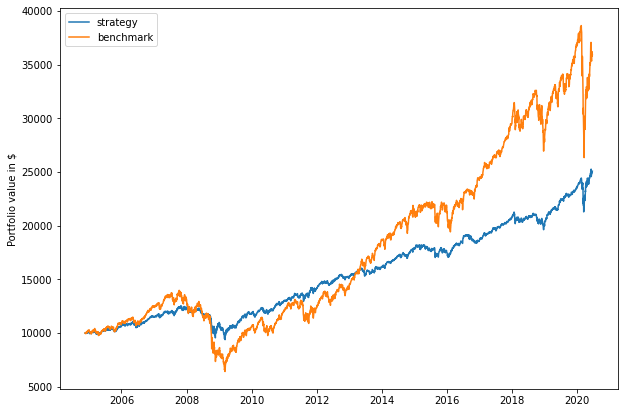

In [17]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

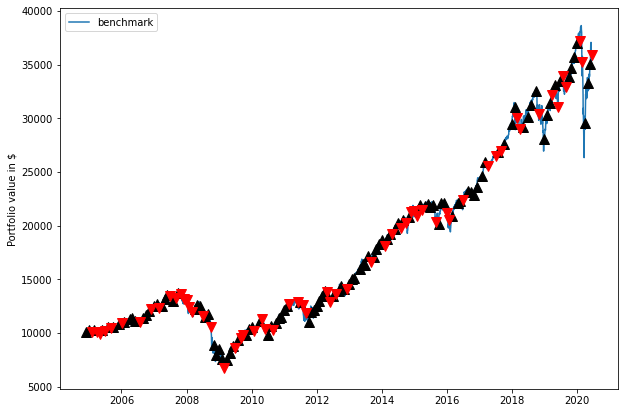

In [18]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

In [19]:
df = pf.summary(stats, benchmark.stats, metrics=pf.currency_metrics)
df

,strategy,benchmark
beginning_balance,"$10,000.00","$10,000.00"
ending_balance,"$25,074.22","$35,927.49"
total_net_profit,"$15,074.22","$25,927.49"
gross_profit,"$17,895.05","$25,927.49"
gross_loss,"-$2,820.83",$0.00


,strategy,benchmark
annual_return_rate,6.07,8.55
max_closed_out_drawdown,-25.04,-54.09
drawdown_annualized_return,-4.12,-6.33
drawdown_recovery,-1.36,-1.41
best_month,12.85,21.12
worst_month,-12.88,-30.70
sharpe_ratio,0.77,0.63
sortino_ratio,0.98,0.76
monthly_std,2.04,4.26


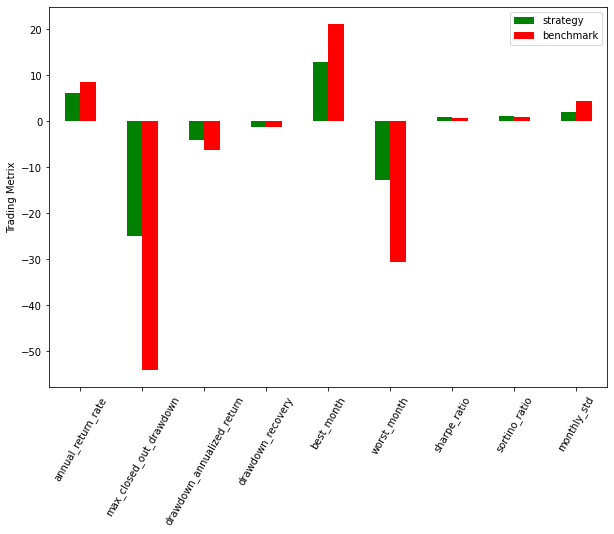

In [20]:
df = pf.plot_bar_graph(stats, benchmark.stats)
df